# Sample Stopping Distances
The purpose of this notebook is to study how stopping distances varies for projectiles that enter the surface at different locations.

Set up the multiprocessing environment. Allows multiple processes to use tensorflow, though they will contend for resources.

In [1]:
from multiprocessing import set_start_method
set_start_method('spawn')

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm
import pickle as pkl
import numpy as np
import os

## Load in the Distance Computer
That is all we need to run this test

In [3]:
%%time
with open('stop_dist_computer.pkl', 'rb') as fp:
    stop_comp = pkl.load(fp)

Using TensorFlow backend.


CPU times: user 4.27 s, sys: 1.2 s, total: 5.48 s
Wall time: 4.56 s


## Run a Single Trajectory as Baseline
We will run the stopping power along the channel to get an idea for a maximum stopping distance

In [4]:
%%time
stop_dist, traj = stop_comp.compute_stopping_distance([0, 0.75, 0.75], [4, 0, 0], output=1000)

Step: 42327 - Time: 42323.27768057986 - Velocity: 0.3999697229897942 - Position: 103304.53086803526
CPU times: user 39min 32s, sys: 4.63 s, total: 39min 37s
Wall time: 39min 36s


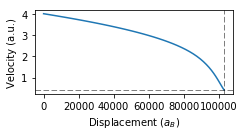

In [5]:
fig, ax = plt.subplots()

ax.plot(traj['displacement'], traj['velocity'])
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')

# Plot the stopping distance and time
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), [0.4]*2, 'k--', lw=0.5)
ax.plot([stop_dist]*2, ax.get_ylim(), 'k--', lw=0.5)


fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Finding*: It does work and we have a standard to compare all of the subsequent calculations.

## Run Many Trajectories in the $\left<1 1 1\right>$ Direction
This will simulate the stopping distances for projectiles impinging on a $(111)$ Al surface. The direction does not vary, so we only vary the starting location. For convenience, I just sample points randomly in the unit cell because the stopping distances are so much greater than the size of a unit cell it doesn't really matter if I have them start along the $(111)$ plane.

In [6]:
traj_dir = [1, 0, 0]
traj_dir = np.divide(traj_dir, np.linalg.norm(traj_dir)) * 4
print('Starting direction: ', traj_dir)

Starting direction:  [4. 0. 0.]


In [7]:
start_points = np.random.rand(64, 3)
print('Generated {} starting points'.format(len(start_points)))

Generated 64 starting points


Make the function to be executed

In [8]:
fun = partial(stop_comp.compute_stopping_distance, output=1000, start_velocity=traj_dir, status=False)

In [9]:
%%time
results = []
for s in start_points:
    try:
        results.append(fun(s))
    except RuntimeError:
        continue
stop_dists, stop_trajs = zip(*results)

Step: 23170 - Time: 23166.277680579857 - Velocity: 0.39925058626105453 - Position: 43033.78575339407
Step: 35954 - Time: 35950.27768057986 - Velocity: 0.3999172038671868 - Position: 83127.11724886316
Step: 41323 - Time: 41319.27768057986 - Velocity: 0.3999263459103731 - Position: 100220.08625449073
Step: 41707 - Time: 41703.27768057986 - Velocity: 0.39996706714729874 - Position: 101374.30683392938
Step: 41806 - Time: 41802.27768057986 - Velocity: 0.39996887444700435 - Position: 101484.54743280691
Step: 42226 - Time: 42222.27768057986 - Velocity: 0.3999758064188685 - Position: 102953.6019563487
Step: 32676 - Time: 32672.277680579857 - Velocity: 0.39974449620580743 - Position: 72555.90558607796
Step: 27192 - Time: 27188.277680579857 - Velocity: 0.3996183215339811 - Position: 56319.70970719931
Step: 39175 - Time: 39171.27768057986 - Velocity: 0.39999771721189026 - Position: 93134.1050223092
Step: 35652 - Time: 35648.27768057986 - Velocity: 0.39997912320227025 - Position: 81957.62780093432

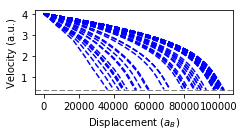

In [10]:
fig, ax = plt.subplots()

for traj in stop_trajs:
    ax.plot(traj['displacement'], traj['velocity'], 'b--')
    
# Plot the stopping distance and time
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), [0.4]*2, 'k--', lw=0.5)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')

fig.set_size_inches(3.5, 2)
fig.tight_layout()

## Save the Data
For later analysis

In [11]:
with open('111_results.pkl', 'wb') as fp:
    pkl.dump({'start_pos': start_points,
             'trajectories': stop_trajs,
             'distances': stop_dists}, fp)